<a href="https://colab.research.google.com/github/mehmetkesik/tensorflow-basics/blob/main/05_transfer_learning_in_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [2]:
# Check if we're using a GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Downloading helper functions

We've done this for some of the functions: https://raw.githubusercontent.com/mehmetkesik/tensorflow-basics/main/helper_functions.py

In [18]:
# Download helper functions
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exist, skipping download...")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mehmetkesik/tensorflow-basics/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import *

helper_functions.py already exist, skipping download...


> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [19]:
# Get 10% of training data of 10 classes of Food101
if Path("10_food_classes_10_percent").is_dir():
    print("10_food_classes_10_percent already exist, skipping donwload...")
else:
    import zipfile

    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

    # Unzip our data
    unzip_data("10_food_classes_10_percent.zip")

10_food_classes_10_percent already exist, skipping donwload...


In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import sklearn

In [21]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
)

test_data = image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch data
for images, labels in train_data_10_percent.take(1):
  print(images.shape, labels.shape)

(32, 224, 224, 3) (32, 10)


## Model 0: Building a transfer learning model using the Keras Function API

The sequential API is straight-forward, it runs our layers in sequential order.

But the function API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [22]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                  experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20221128-103345
Epoch 1/5
24/24 [==============================] - 106s 4s/step - loss: 1.8785 - accuracy: 0.3960 - val_loss: 1.2866 - val_accuracy: 0.7253
Epoch 2/5
24/24 [==============================] - 89s 4s/step - loss: 1.0962 - accuracy: 0.7547 - val_loss: 0.8395 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 88s 4s/step - loss: 0.7894 - accuracy: 0.8320 - val_loss: 0.6731 - val_accuracy: 0.8602
Epoch 4/5
24/24 [==============================] - 90s 4s/step - loss: 0.6406 - accuracy: 0.8480 - val_loss: 0.5678 - val_accuracy: 0.8586
Epoch 5/5
24/24 [==============================] - 94s 4s/step - loss: 0.5577 - accuracy: 0.8667 - val_loss: 0.5222 - val_accuracy: 0.8750


In [13]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 157s 2s/step - loss: 0.5448 - accuracy: 0.8640


[0.5448346734046936, 0.8640000224113464]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

In [ ]:
# How about we get a summary of the base model
base_model_summary = base_model.summary()
print(base_model_summary)

In [42]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


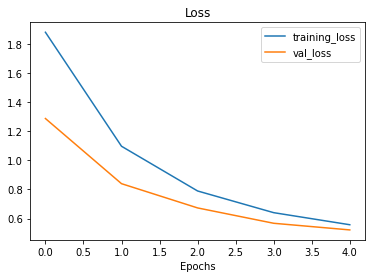

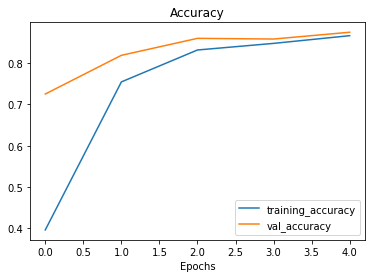

In [43]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [49]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [50]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1``- use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [52]:
# Download and unzip data - preprocessed from Food101
if Path("10_food_classes_1_percent").is_dir():
    print("10_food_classes_1_percent already exist, skipping donwload...")
else:
    import zipfile

    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

    # Unzip our data
    unzip_data("10_food_classes_1_percent.zip")


10_food_classes_1_percent already exist, skipping donwload...


In [53]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [54]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'

In [55]:
# Setup data loaders

train_data_1_percent = image_dataset_from_directory(
    train_dir_1_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE, # default = 32
)

test_data = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [92]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.Rescaling(1./255), # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2)
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

10_food_classes_1_percent/train/ramen/196184.jpg


(-0.5, 452.5, 314.5, -0.5)

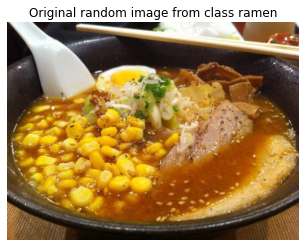

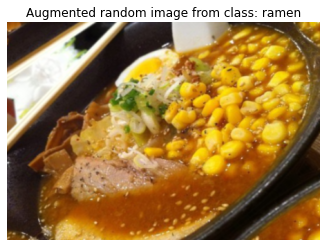

In [86]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [94]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.Input(shape=input_shape, name="input_layer")
#print(f"input shape: {inputs.shape}")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)
#print(f"aug shape: {x.shape}")

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [95]:
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20221128-134346
Epoch 1/5
3/3 [==============================] - 57s 23s/step - loss: 2.3520 - accuracy: 0.1000 - val_loss: 2.3085 - val_accuracy: 0.0921
Epoch 2/5
3/3 [==============================] - 45s 22s/step - loss: 2.3357 - accuracy: 0.1000 - val_loss: 2.3054 - val_accuracy: 0.0970
Epoch 3/5
3/3 [==============================] - 87s 43s/step - loss: 2.3329 - accuracy: 0.0857 - val_loss: 2.3067 - val_accuracy: 0.1168
Epoch 4/5
3/3 [==============================] - 46s 22s/step - loss: 2.3236 - accuracy: 0.1000 - val_loss: 2.3138 - val_accuracy: 0.1184
Epoch 5/5
3/3 [==============================] - 46s 22s/step - loss: 2.3148 - accuracy: 0.1000 - val_loss: 2.3330 - val_accuracy: 0.0773


In [96]:
model_1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [97]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 186s 2s/step - loss: 2.3229 - accuracy: 0.1000


[2.3229243755340576, 0.10000000149011612]

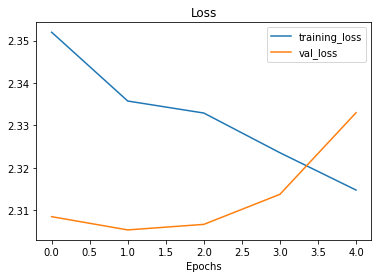

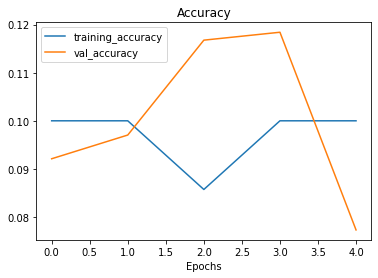

In [98]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)